In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [23]:
import time                                                

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [24]:
import pandas as pd
import numpy as np

import stop_words
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


In [25]:
import pickle


def pickle_dump(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
def pickle_load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [26]:
def fetch():
    train_haptik = pd.read_csv('./train_data.csv', encoding='UTF-8')
    test_haptik = pd.read_csv('./test_data.csv', encoding='UTF-8')
    return train_haptik, test_haptik

In [27]:
def feature_target_separator(df):
    feature = df.iloc[:,0]
    target = df.iloc[:,1:]
    return feature, target

In [28]:
@timeit
def reverse_ohe(df):
    for column in df.columns:
        df[column] = df[column].astype(str).map({'F':0, 'T':1})
    df = df.idxmax(1)
    return df


In [29]:
@timeit
def preprocess(listlikeobj):
    tokenizer_obj= TreebankWordTokenizer()
    ps = PorterStemmer()
    listlikeobj = [x.lower() for x in listlikeobj]
    tokens = [tokenizer_obj.tokenize(x) for x in listlikeobj]
    stopwords = stop_words.get_stop_words('english')
    #stopwords.extend(['{','}', 'task_name', 'api_name', 'product_id', "n't", 'thank'])
    listlikeobj = [list(set(x).difference(set(stopwords))) for x in tokens]
    #listlikeobj = [map(ps.stem,x) for x in listlikeobj]
    return listlikeobj
    

In [30]:
@timeit
def word_cloud(list_of_tokens):
    temp_list = []
    _ = [temp_list.extend(x) for x in list_of_tokens]
    word_cloud_object = WordCloud(max_font_size=30)
    word_cloud_object.generate(' '.join(temp_list))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud_object)
    #print(temp_list)

In [31]:
train, test = fetch()

train_feature_haptik, train_target_haptik = feature_target_separator(train)
train_target_haptik = reverse_ohe(train_target_haptik)

test_feature_haptik, test_target_haptik = feature_target_separator(test)
test_target_haptik = reverse_ohe(test_target_haptik)


/home/daksha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


'reverse_ohe'  941.91 ms
'reverse_ohe'  736.49 ms


In [32]:
list_of_train_tokens = preprocess(train_feature_haptik)
list_of_test_tokens = preprocess(test_feature_haptik)

'preprocess'  7690.77 ms
'preprocess'  2295.01 ms


'word_cloud'  3284.02 ms


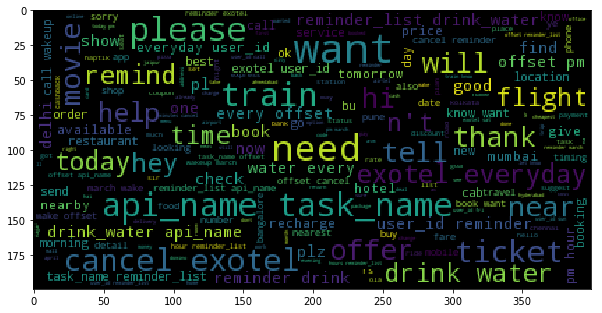

In [33]:
word_cloud(list_of_train_tokens)

'word_cloud'  1336.30 ms


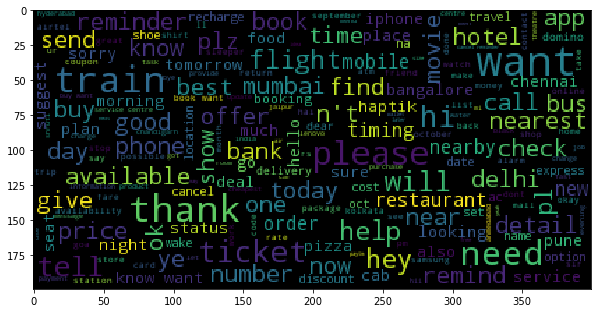

In [34]:
word_cloud(list_of_test_tokens)

In [35]:
def createDF(message_list,category_df):
    m_series = pd.Series(message_list)
    m_series = m_series.apply(lambda x:' '.join(x))
    fin_df = pd.concat([m_series,category_df],axis=1)
    fin_df = fin_df.rename(columns={0:'message',1:'category'})
    return fin_df
    


In [36]:
train_df = createDF(list_of_train_tokens,train_target_haptik)
test_df = createDF(list_of_test_tokens,test_target_haptik)

In [59]:
def train_clf(df):
    t = TreebankWordTokenizer()
    sw = stop_words.get_stop_words('english')
    df = df.sample(frac=1, replace=False)
    X_train = df['message']
    Y_train = df['category']
    vect = TfidfVectorizer(stop_words=sw,tokenizer=t.tokenize,ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1')
    X_train_dtm = vect.fit_transform(X_train)
    clf = MultinomialNB(alpha=0.25, fit_prior=False)
    clf.fit(X_train_dtm,Y_train)
    print(clf)
    return clf,vect

train_clf(train_df)

MultinomialNB(alpha=0.25, class_prior=None, fit_prior=False)


(MultinomialNB(alpha=0.25, class_prior=None, fit_prior=False),
 TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=0.5, max_features=None, min_df=2,
         ngram_range=(1, 2), norm=u'l1', preprocessor=None, smooth_idf=True,
         stop_words=[u'a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any', u'are', u"aren't", u'as', u'at', u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by', u"can't", u'cannot', u'could', u"couldn't", u'did', u"didn't", u...", u'you', u"you'd", u"you'll", u"you're", u"you've", u'your', u'yours', u'yourself', u'yourselves'],
         strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b',
         tokenizer=<bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7fc901deef50>>

In [60]:
def classify((clf_obj,vect),df):
    df = df.sample(frac=1, replace=False)
    X_test = df['message']
    Y_test = df['category']
    #vect = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.2)
    X_test_dtm = vect.transform(X_test)
    Y_pred = clf_obj.predict(X_test_dtm)
    print(accuracy_score(Y_test,Y_pred))
    print(classification_report(Y_test,Y_pred))
    print()
    print(confusion_matrix(Y_test,Y_pred))
    print()
    print(cross_val_score(clf_obj,X_test_dtm,Y_test,cv=10))
    return Y_pred

In [61]:
classify(train_clf(train_df),test_df)

MultinomialNB(alpha=0.25, class_prior=None, fit_prior=False)
0.7991
             precision    recall  f1-score   support

     casual       0.85      0.84      0.84      3249
       food       0.76      0.65      0.70       810
     movies       0.82      0.75      0.78       434
     nearby       0.68      0.72      0.70       692
      other       0.86      0.70      0.77      1619
   recharge       0.54      0.86      0.66       324
  reminders       0.81      0.85      0.83       859
    support       0.69      0.58      0.63       220
     travel       0.81      0.91      0.86      1793

avg / total       0.81      0.80      0.80     10000


[[2735   53   30   34   64   79   98   19  137]
 [  66  525    6   39   16   79   27    1   51]
 [  12    1  324   21    3    0    1    1   71]
 [  58   23    5  498   44   16    7    9   32]
 [ 190   58   18   75 1137   44   27   24   46]
 [  11    7    2    3    7  280    4    0   10]
 [  72    6    3    2   12   10  728    1   25]
 [  19   

array([u'travel', u'recharge', u'casual', ..., u'casual', u'travel',
       u'travel'], 
      dtype='<U9')